In [16]:
from sena.data.norec_sentence.dataloader import load_full_dataset
import sena.utils.utils as utils
import pandas as pd

In [17]:
data = load_full_dataset()

train = data["train"]
val = data["dev"]
test = data["test"]

train = utils.clean_text(train, "text")
val = utils.clean_text(val, "text")
test = utils.clean_text(test, "text")

combined_data = pd.concat([train, val, test])

In [18]:
from collections import Counter
import math

num_words = Counter()
for review in combined_data["text"]:
    for word in review.split(" "):
        num_words[word] += 1

num_words = len(num_words)
num_words = math.ceil(num_words / 1000) * 1000
print("Number of words:", num_words)

Number of words: 26000


<AxesSubplot:>

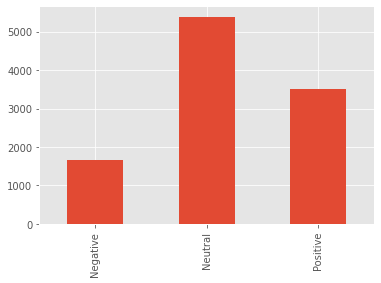

In [19]:
combined_data["label"].replace({0: "Negative", 1: "Neutral", 2: "Positive"}).value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

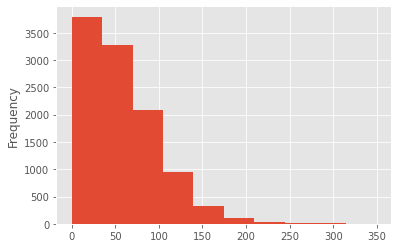

In [20]:
combined_data["text"].str.len().plot.hist()

In [21]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

X_train, y_train = train["text"], train["label"]
X_val, y_val = val["text"], val["label"]
X_test, y_test = test["text"], test["label"]

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(combined_data["text"])

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [22]:
from collections import Counter

combined_text = tokenizer.texts_to_sequences(combined_data["text"])

word_counter = Counter()
for review in combined_text:
    for word in review:
        word_counter[tokenizer.index_word[word]] += 1

In [23]:
word_counter.most_common(10)

[('the', 307),
 ('får', 289),
 ('litt', 261),
 ('to', 258),
 ('år', 252),
 ('gjør', 231),
 ('helt', 213),
 ('godt', 212),
 ('første', 210),
 ('filmen', 204)]

In [24]:
maxlen = 80
X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

y_train = to_categorical(y_train, 3)
y_val = to_categorical(y_val, 3)
y_test = to_categorical(y_test, 3)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape, end="\n\n")
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape, end="\n\n")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7973, 80)
y_train shape: (7973, 3)

X_val shape: (1411, 80)
y_val shape: (1411, 3)

X_test shape: (1181, 80)
y_test shape: (1181, 3)


In [25]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.regularizers import l2

model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=128))
model.add(LSTM(units=128, dropout=0.3, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01),
               bias_regularizer=l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [26]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         3328000   
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 3,459,971
Trainable params: 3,459,971
Non-trainable params: 0
_________________________________________________________________


In [27]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=3)

epochs = 20
batch_size = 16
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1,
                    callbacks=[early_stop])

Epoch 1/20
499/499 [==============================] - 45s 86ms/step - loss: 1.9548 - accuracy: 0.5389 - val_loss: 1.3591 - val_accuracy: 0.5741
Epoch 2/20
499/499 [==============================] - 49s 97ms/step - loss: 0.9731 - accuracy: 0.7144 - val_loss: 1.0652 - val_accuracy: 0.5882
Epoch 3/20
499/499 [==============================] - 49s 99ms/step - loss: 0.5790 - accuracy: 0.7946 - val_loss: 1.1159 - val_accuracy: 0.5804
Epoch 4/20
499/499 [==============================] - 42s 83ms/step - loss: 0.4343 - accuracy: 0.8252 - val_loss: 1.3108 - val_accuracy: 0.5571
Epoch 5/20
499/499 [==============================] - 45s 91ms/step - loss: 0.3487 - accuracy: 0.8965 - val_loss: 1.5125 - val_accuracy: 0.5351


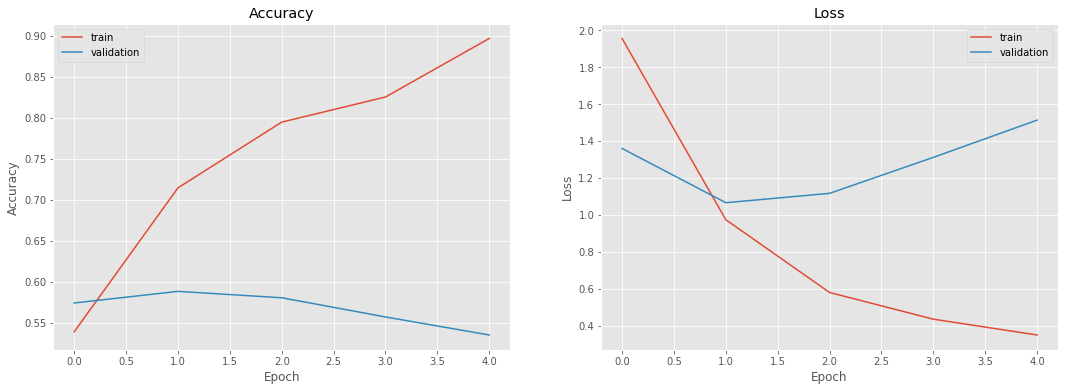

In [28]:
from sena.utils.utils import plot_history

plot_history(history)

In [29]:
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=1)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

37/37 [==============================] - 2s 51ms/step - loss: 1.4547 - accuracy: 0.5292
Validation loss: 1.4546899795532227
Validation accuracy: 0.5292125344276428


In [30]:
from datetime import datetime

if val_acc > 0.8:
    model.save(f"models/SA-LSTM-MULTICLASS-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")